<b>Natural Language Processing with Disaster Tweets </b> <br><br>
This Kaggle competition has us classify tweets using Natural Language Processing (NLP) into two categories: being related to a real-world disaster or not being related to a disaster. The dataset contains around 10k hand-classified tweets split into training and testing sets. <br>
This dataset was created by the company figure-eight and can be found at https://www.kaggle.com/c/nlp-getting-started.


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
from random import sample
import re
import string
from collections import Counter
import wordcloud
import spacy
from spacy.lang.en.stop_words import STOP_WORDS
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
import tensorflow as tf
from sklearn.ensemble import RandomForestClassifier

In [4]:
spacy.prefer_gpu()
nlp = spacy.load('en_core_web_sm')

<b> Exploratory Data Analysis </b><br><br>
The dataset has five columns; the location the tweet was sent from, a keyword from that tweet (may be blank in certain cases) and the text itself. The 'target' column is our ground-truth label (1 for disaster, 0 otherwise) and the 'id' is a unique identifier for the tweet (we won't need this column in training, it is only used to match the output to a particular tweet in the test set).<br>
I decided to remove 'location' and 'keyword' right off the bat, there are blank values for around 1/3 of the training dataset and it is simply not feasible to encode so many areas (and keywords) in a reasonable manner. There are three graphs to show the distribution of target values as well as the number of words per tweet category. I've also included two wordclouds to show which words were occuring the most in a particular category.<br><br>
The most important part, however, is the 'process_text' function. Some tweets contain redundant information, such as links, punctuation or numbers and, of course, emojis since we're dealing with a social network. I've also removed the so-called stop words (a, the, and, in, etc.) which do not contribute much to the context of the tweet using the Spacy library designed for NLP tasks.

In [5]:
df_train = pd.read_csv('train.csv')
df_test = pd.read_csv('test.csv')

In [4]:
print(df_train.shape)
print(df_train.head())

(7613, 5)
   id keyword location                                               text  \
0   1     NaN      NaN  Our Deeds are the Reason of this #earthquake M...   
1   4     NaN      NaN             Forest fire near La Ronge Sask. Canada   
2   5     NaN      NaN  All residents asked to 'shelter in place' are ...   
3   6     NaN      NaN  13,000 people receive #wildfires evacuation or...   
4   7     NaN      NaN  Just got sent this photo from Ruby #Alaska as ...   

   target  
0       1  
1       1  
2       1  
3       1  
4       1  


In [5]:
print(df_train.columns)
print(df_train.dtypes)

Index(['id', 'keyword', 'location', 'text', 'target'], dtype='object')
id           int64
keyword     object
location    object
text        object
target       int64
dtype: object


In [6]:
# get the number of nan values in each column
print(df_train.isnull().sum())

id             0
keyword       61
location    2533
text           0
target         0
dtype: int64


In [4]:
df_train['keyword'].value_counts()

keyword
fatalities               45
deluge                   42
armageddon               42
sinking                  41
damage                   41
                         ..
forest%20fire            19
epicentre                12
threat                   11
inundation               10
radiation%20emergency     9
Name: count, Length: 221, dtype: int64

In [10]:
df_train['location'].value_counts()

location
USA                    104
New York                71
United States           50
London                  45
Canada                  29
                      ... 
MontrÌ©al, QuÌ©bec       1
Montreal                 1
ÌÏT: 6.4682,3.18287      1
Live4Heed??              1
Lincoln                  1
Name: count, Length: 3341, dtype: int64

In [5]:
# print the top 10 words in the text
cnt = Counter()
for text in df_train['text']:
    for word in text.split():
        cnt[word] += 1
print(cnt.most_common(10))

[('the', 2575), ('a', 1845), ('to', 1805), ('in', 1757), ('of', 1722), ('and', 1302), ('I', 1197), ('for', 820), ('is', 814), ('on', 773)]


In [6]:
# plot the average word count by target
df_train['word_count'] = df_train['text'].apply(lambda x: len(x.split()))
print(df_train.groupby('target')['word_count'].mean())

target
0    14.704744
1    15.167533
Name: word_count, dtype: float64


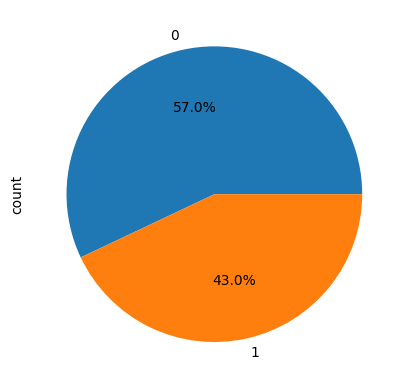

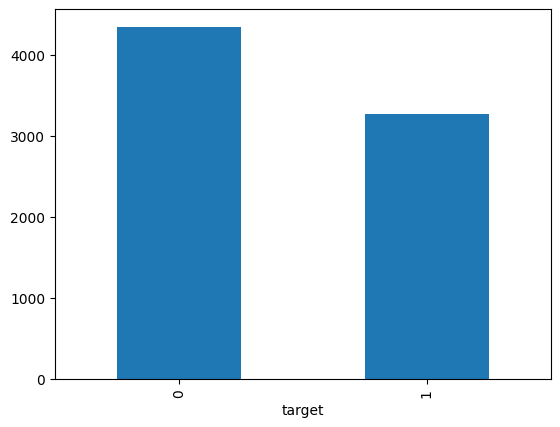

In [5]:
# plot a pie chart and a bar chart of the target distribution
df_train['target'].value_counts().plot.pie(autopct='%1.1f%%')
plt.show()
df_train['target'].value_counts().plot.bar()
plt.show()

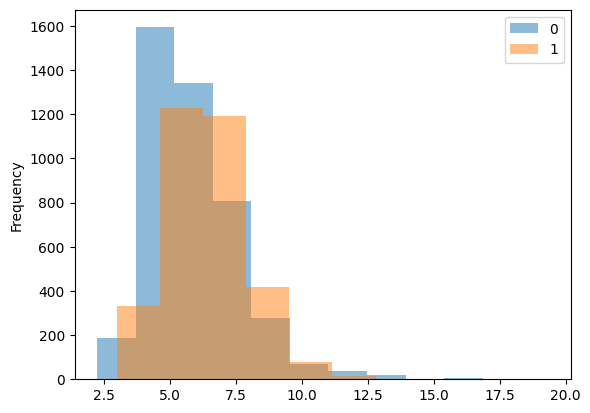

In [7]:
# plot histograms of mean word lengths by target
df_train['mean_word_length'] = df_train['text'].apply(lambda x: np.mean([len(word) for word in x.split()]))
df_train.groupby('target')['mean_word_length'].plot.hist(alpha=0.5)
plt.legend()
plt.show()

In [8]:
# text cleaning

def remove_emoji(text):
    emoji_pattern = re.compile("["
                               u"\U0001F600-\U0001F64F"  # emoticons
                               u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                               u"\U0001F680-\U0001F6FF"  # transport & map symbols
                               u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                               u"\U00002702-\U000027B0"
                               u"\U000024C2-\U0001F251"
                               "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)

def remove_punctuation(text):
    return text.translate(str.maketrans('', '', string.punctuation))

def remove_html(text):
    html = re.compile(r'<.*?>')
    return html.sub(r'',text)

def remove_stopwords(text):
    return ' '.join([word for word in text.split() if word not in STOP_WORDS])

def remove_url(text):
    url = re.compile(r'https?://\S+|www\.\S+')
    return url.sub(r'',text)

def remove_numbers(text):
    remove_digits = str.maketrans('', '', string.digits)
    return text.translate(remove_digits)

def tokenize(text):
    return [token.text for token in nlp(text)]

def process_text(text):
    text = text.lower()
    text = remove_emoji(text)
    text = remove_punctuation(text)
    text = remove_html(text)
    text = remove_stopwords(text)
    text = remove_url(text)
    text = ' '.join(tokenize(text))
    text = remove_numbers(text)
    
    return text

# apply on both train and test data
df_train['text'] = df_train['text'].apply(process_text)
df_test['text'] = df_test['text'].apply(process_text)

In [7]:
# display the cleaned text
df_train['text']

0                   deeds reason earthquake allah forgive
1                   forest fire near la ronge sask canada
2       residents asked shelter place notified officer...
3        people receive wildfires evacuation orders ca...
4       got sent photo ruby alaska smoke wildfires pou...
                              ...                        
7608    giant cranes holding bridge collapse nearby ho...
7609    ariaahrary thetawniest control wild fires cali...
7610          m  utc km s volcano hawaii httptcozdtoydebj
7611    police investigating ebike collided car little...
7612    latest homes razed northern california wildfir...
Name: text, Length: 7613, dtype: object

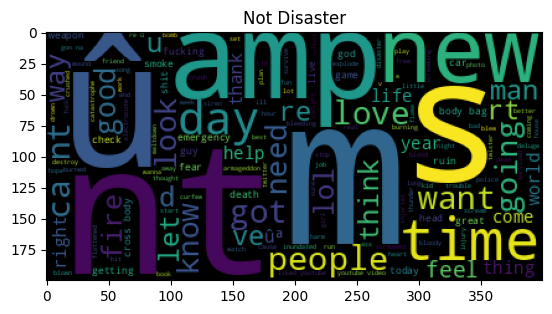

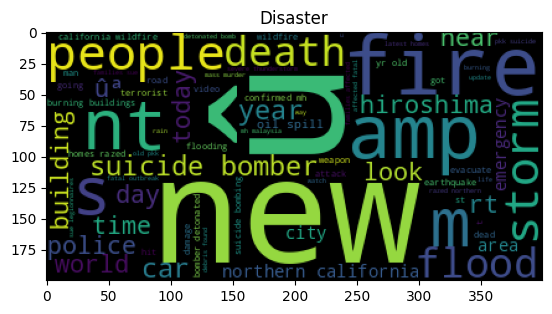

In [13]:
# plot the word cloud by target
wc = wordcloud.WordCloud()
df_train_0 = df_train[df_train['target'] == 0]
df_train_1 = df_train[df_train['target'] == 1]
wc.generate(' '.join(df_train_0['text']))
plt.imshow(wc)
plt.title('Not Disaster')
plt.show()
wc.generate(' '.join(df_train_1['text']))
plt.imshow(wc)
plt.title('Disaster')
plt.show()

In [9]:
# drop redundant columns
df_train = df_train.drop(columns=['id','keyword', 'location', 'word_count', 'mean_word_length'])

<b>Model Architecture </b><br><br>
There are two models in this notebook, a Recurrent Neural Network (RNN) and a 'vanilla' machine learning algorithm, the Random Forest classifier. Naturally, the text of the tweet has to be represented in such a way that the algorithms can perform their usual calculations to arrive at a conclusion. Enter tf-idf (term frequency–inverse document frequency) vectorizer, which quantifies the importance of a term in a document with respect to its frequency in the document and its rarity across multiple documents.<br><br> The formula <i>tf(t,d) * idf(t,D)</i> is given as:<br>
 <i>tf(t,d) = # of times term t appears in document d / total number of terms in document d </i> <br>
 <i>idf(t,D) = log( # of documents in corpus N/ # of documents containing term t) </i> <br><br>
Once the text has been vectorized, we can feed it to the models. I won't discuss the Random Forest algorithm as this class focuses on Deep Learning methods, it is here purely as a comparison tool. 
As for the RNN, first, we set up a text vectorization layer with a maximum of 1,000 tokens. This layer (encoder) is responsible for converting raw text into numerical representations that can be fed into the neural network. The encoder is adapted to the training dataset by mapping over the text data, which allows it to learn the vocabulary and the frequency of words.<br>
The RNN uses a sequential model which is a linear stack of layers. The first layer is the previously defined encoder, followed by an embedding layer. The embedding layer transforms the integer-encoded words into dense vectors of fixed size (128 in this case), and mask_zero=True ensures that padding tokens are ignored in the model.
Next, a bidirectional LSTM (Long Short-Term Memory) layer is added. This layer processes the input sequence in both forward and backward directions, capturing context from both ends of the sequence. The LSTM layer has 128 units, which determines the dimensionality of the output space.
Following the LSTM layer, there are several dense layers. The first one has 64 units with a ReLU activation function, which introduces non-linearity into the model. A dropout layer with a rate of 0.5 is included to prevent overfitting by randomly setting half of the input units to zero during training. Another dense layer with 16 units and ReLU activation is added, followed by the final dense layer with a single unit and a sigmoid activation function. The sigmoid activation is used for binary classification, outputting a probability value between 0 and 1.

    

In [10]:
# feature extraction on training data
train_corpus = df_train["text"].tolist()
vector = TfidfVectorizer(max_features=1000)
interemresponse = vector.fit(train_corpus)

train_and_val = interemresponse.transform(df_train["text"]).todense()

X_train, X_val, y_train, y_val = train_test_split(train_and_val, df_train["target"], test_size=0.08, random_state=42)

X_test = interemresponse.transform(df_train["text"]).todense()

print(X_train.shape, X_val.shape, X_test.shape)
print(y_train.shape, y_val.shape)

(7003, 1000) (610, 1000) (7613, 1000)
(7003,) (610,)


In [ ]:
"""
split the data into training and validation sets, create tensorflow Dataset objects,
convert the text to tensors, shuffle the training data, and batch the data
"""
num_train = math.floor((0.92) * df_train.shape[0])
train_rows = sample([i for i in range(df_train.shape[0])], num_train)
val_rows = [i for i in range(df_train.shape[0]) if not i in train_rows]

training_df = df_train.iloc[train_rows]
validation_df = df_train.iloc[val_rows]

features = "text"
training_dataset = (
    tf.data.Dataset.from_tensor_slices((
            tf.cast(training_df[features].values, tf.string),
            tf.cast(training_df['target'].values, tf.int32)
        )
    )
)

validation_dataset = (
    tf.data.Dataset.from_tensor_slices((
            tf.cast(validation_df[features].values, tf.string),
            tf.cast(validation_df['target'].values, tf.int32)
        )
    )
)
test_dataset = (
    tf.data.Dataset.from_tensor_slices((
            tf.cast(df_test["text"].values, tf.string)
        )
    )
)

training_dataset = training_dataset.shuffle(10000).batch(10)
validation_dataset = validation_dataset.batch(10)
test_dataset = test_dataset.batch(10)

In [14]:
num_words = 1000
encoder = tf.keras.layers.TextVectorization(max_tokens = num_words)
encoder.adapt(training_dataset.map(lambda text, label: text))

def RNN():
    model = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(input_dim = len(encoder.get_vocabulary()), output_dim = 128, mask_zero = True),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128)),
    tf.keras.layers.Dense(64, activation = "relu"),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(16, activation = "relu"),
    tf.keras.layers.Dense(1, activation = "sigmoid")])
    
    lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(initial_learning_rate = 5e-5,decay_steps = 1000, decay_rate=0.9) 
  
    model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate = lr_schedule), loss = "binary_crossentropy", metrics = ["accuracy"])
       
    return model

2024-09-27 13:45:30.361856: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [16]:
# train the model
model = RNN()
model.fit(training_dataset, epochs = 12, validation_data = validation_dataset)

Epoch 1/12
701/701 ━━━━━━━━━━━━━━━━━━━━ 28s 29ms/step - accuracy: 0.5621 - loss: 0.6888 - val_accuracy: 0.5836 - val_loss: 0.6776
Epoch 2/12
701/701 ━━━━━━━━━━━━━━━━━━━━ 18s 25ms/step - accuracy: 0.6540 - loss: 0.6534 - val_accuracy: 0.7508 - val_loss: 0.5342
Epoch 3/12
701/701 ━━━━━━━━━━━━━━━━━━━━ 14s 20ms/step - accuracy: 0.8017 - loss: 0.4848 - val_accuracy: 0.7951 - val_loss: 0.4810
Epoch 4/12
701/701 ━━━━━━━━━━━━━━━━━━━━ 19s 27ms/step - accuracy: 0.8167 - loss: 0.4527 - val_accuracy: 0.8033 - val_loss: 0.4501
Epoch 5/12
701/701 ━━━━━━━━━━━━━━━━━━━━ 21s 30ms/step - accuracy: 0.8271 - loss: 0.4269 - val_accuracy: 0.8033 - val_loss: 0.4583
Epoch 6/12
701/701 ━━━━━━━━━━━━━━━━━━━━ 18s 25ms/step - accuracy: 0.8415 - loss: 0.4019 - val_accuracy: 0.8033 - val_loss: 0.4518
Epoch 7/12
701/701 ━━━━━━━━━━━━━━━━━━━━ 19s 27ms/step - accuracy: 0.8415 - loss: 0.3970 - val_accuracy: 0.8016 - val_loss: 0.4551
Epoch 8/12
701/701 ━━━━━━━━━━━━━━━━━━━━ 23s 33ms/step - accuracy: 0.8404 - loss: 0.3997 - 

<b>Results, Analysis and Conclusion </b><br><br>
Both the RNN and the Random Forest performed reasonably well, scoring 78.7% and 77.3% respectively on the Kaggle leaderboard (see attached screenshots below). I initially wanted to test out an LLM such as Bert or Distilbert to classify the text, but that did not come to fruition due to time constraints. As for hyperparameter tuning, increasing RNN epochs and changing dropout percentage mostly led to overfitting on the test data, so I just stuck with 12 and 0.5. There is no hyperparameter tuning done on the Random Forest classifier, the baseline model performs almost on par with the neural network even without deploying methods such as GridSearchCV, which kind of begs the question whether creating a suitable neural network architecture is worth the hassle. <br>
My personal takeaways from this assignment are discovering the intricacies of LSTM as well as revising NLP preprocessing steps acquired in a previous class, this time using Spacy instead of NLTK

In [17]:
# predict on test data
yhat = model.predict(test_dataset)
yhat = yhat.reshape(yhat.shape[0],)
yhat = yhat.tolist()
predictions = [round(yhat[i]) for i in range(len(yhat))]
submission = pd.DataFrame({'id': df_test['id'], 'target': predictions})
submission.to_csv('submision.csv', index=False)

327/327 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step


![rnn](rnn.png) 

In [67]:
# random forest classifier
# train the model
rfc = RandomForestClassifier(n_estimators=100, random_state=42)
X_train = np.asarray(X_train)
y_train = np.asarray(y_train)
X_val = np.asarray(X_val)
y_val = np.asarray(y_val)
rfc.fit(X_train, y_train)
print(rfc.score(X_val, y_val))


0.7491803278688525


In [87]:
# feature extraction on test data
X_test = interemresponse.transform(df_test["text"]).todense()
print(X_test)

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [91]:
# predict on the test data
X_test = np.asarray(X_test)
predictions = rfc.predict(X_test)

submission = pd.DataFrame({'id': df_test['id'], 'target': predictions})
submission.to_csv('submission_rf.csv', index=False)

![rf](rf.png) 